# Análisis de sentimientos

Es el proceso mediante el cual se busca detectar en un fragmento de texto los siguientes apartados:
    
    - Subjetividad, diferencia el contenido objetivo (hechos) del subjetivo (opiniones)
    - Polaridad, u orientación media de la emoción expresada. En general, positivo vs negativo y en ocasiones neutro.
    - Intensidad, fuerza del sentimiento u opinión expresada a veces en los documentos.

### Librerías y funciones necesarias

In [1]:
import pandas as pd
import numpy as np
import gzip
import os
import random
import operator

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Sets the value of the specified option
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [2]:
# Función que realiza comprobaciones sobre una columna de un dataframe
def check_column(df, col_name):
    values_unique = len(df[col_name].unique())
    values_nan = df[col_name].isnull().sum()
    portmissing = round((df[col_name].isnull().sum()/len(df))*100, 4)
    
    print (f'{col_name} consta de: {values_unique} valores distintos de un total de {len(df)}')
    print (f'{col_name} consta de: {values_nan} valores ausentes, {portmissing}%')

In [3]:
# Función que devuelve la longitud del corpus de una columna de un dataframe
def lenCorpus(df, col_name):
  numTokens = set()
  for x in df[col_name]:
    for w in x.strip().split(' '):
      numTokens.add(w.strip())
  return len(numTokens)

In [4]:
# Función que dibuja la matriz de confusión
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicciones')
    plt.ylabel('Ground Truth')

    plt.tight_layout()
    plt.show()

### Carga de datos a través de un fichero pkl del notebook anterior

Desde Amazon product data (Files "small" subsets for experimentation) con URL http://jmcauley.ucsd.edu/data/amazon/ descargamos los siguientes subsets:
    - Digital Music               (64,706 reviews)
    - Clothing, Shoes and Jewelry (278,677 reviews)
    - Health and Personal Care    (346,355 reviews)
    - Sports and Outdoors         (296,337 reviews)
    
5-core (9.9gb) - subset of the data in which all users and items have at least 5 reviews (41.13 million reviews)

En el notebook 0_AnalisisSentimientos_sintratamiento.ipynb guardamos el datafame en formato pkl que procederemos a recuperar.

In [5]:
# Cargamos el df resultante guardado en el notebook anterior sobre el df con nombre df_newamazon
# Load pickled pandas object (or any object) from file.
df_newamazon = pd.read_pickle('df_amazoncompleto.pkl')

print(f'Dimensiones del dataframe df_newamazon: ', df_newamazon.shape)

Dimensiones del dataframe df_newamazon:  (20000, 9)


In [6]:
# Verificamos las columnas del df
df_newamazon.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

Detalle del significado de cada variable o columna:

    reviewerID - ID of the reviewer, e.g. A38IRL0X2T4DPF
    asin - ID of the product, e.g. 5555991584
    reviewerName - name of the reviewer
    helpful - helpfulness rating of the review, e.g. 2/3
    reviewText - text of the review
    overall - rating of the product
    summary - summary of the review
    unixReviewTime - time of the review (unix time)
    reviewTime - time of the review (raw)

In [7]:
# Analizamos las columna overall de cada dataset 
check_column(df_newamazon, 'overall')
df_newamazon['overall'].value_counts().head()

overall consta de: 5 valores distintos de un total de 20000
overall consta de: 0 valores ausentes, 0.0%


5.0    4000
4.0    4000
3.0    4000
2.0    4000
1.0    4000
Name: overall, dtype: int64

In [8]:
# Análisis de la columna reviewText para controlar Nan
check_column(df_newamazon, 'reviewText')

reviewText consta de: 19995 valores distintos de un total de 20000
reviewText consta de: 0 valores ausentes, 0.0%


In [9]:
# Visualizamos las primeras filas 
df_newamazon.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A319Y60NW7HS77,B000001EGI,"radiogold ""radiogold""","[2, 21]","Tumbleweed Connection raised Elton to his initial peak audibly with the hit single Country Comfort, and that legendary epic, Burn down the mission. It was the energy of that album that inspired the recording of 11-17-70, Live at the ANR Studios in New York City. In reality, this album was nothing but one long horrible noise. John's talents were wasted, with his vocals drowned in layers of instruments, which unfortunately destroyed the albums ambience. The eighteen minute version of burn down the mission became panned out to the point of very overdone. As much as I love listening to Elton's Music, this album was a rapid fall to failure. The modestly improved &quot;madman across the water&quot; and &quot;Honky chateau&quot;, were released in 1971 and 1972 respectively. but it would be the release of &quot;Don't shoot me, I'm only the piano player&quot;, and &quot;Good-bye yellow brick road&quot; in 1973, that would bring him back to his audible peak, and steer him well clear of this brief trench in his career.",1.0,"Just a brief dip, he would improve again!",1084752000,"05 17, 2004"
1,A15HQSBVCU724Y,B0002XEDSU,Mikky Mouse,"[3, 4]",Im not gonna review on this.. all i can say is that if you one of them trendy thugs that wear a rainbow colored fits & clothing (gay) and dance around in the middle of the streets (like a complete moron).. then go get this album.. If your a real rap listener and knows a definition of rap & Hip Hop.. avoid this album at all costs,1.0,That White Tee song is retarded,1134000000,"12 8, 2005"
2,AZ39SOZT3NZQU,B000FVQYYK,XraySpex,"[4, 67]","I bought this album because I went to a lyric site and their lyrics for a song on Absolution were insightful. Once I received the album I was consumed with disappointment. This world is suffering from the disease of delusion, religion is the opiate of the masses, and it is more destructive than heroin. The ignorance of musicians spouting their idiotic rhetoric, which perpetuates the myths that god exists and we have souls is sickening. Lyrics are a main component of music and musicians have to write lyrics that people can relate to in order to provide catharsis. Hopefully this band will cease to exist so intelligent artists will thrive in our culture and challenge the ignorance that infects everything.",1.0,Put This In A Black Hole,1184544000,"07 16, 2007"


In [10]:
# Nos quedamos con las columnas necesarias para el análisis de sentimientos
df_newamazon = df_newamazon[['overall', 'reviewText']]

print(f'Dimensiones del dataframe df_newamazon: ', df_newamazon.shape)

Dimensiones del dataframe df_newamazon:  (20000, 2)


In [11]:
# Función que define la etiqueta para el análisis de sentimientos multiclase
# según el valor de la columan overall
def label_multisentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    elif int(row['overall']) == 3:
        return 'neu'
    else:
        return 'pos'

In [12]:
# Función que define la etiqueta para el análisis de sentimientos binario
# según el valor de la columan overall
def label_bisentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    else:
        return 'pos'

In [13]:
# Nuevas columnas en el df_newamazon con la etiqueta de los sentimientos según contemplemos problema binario/multiclase
df_newamazon['sentiment_trilabel'] = df_newamazon.apply(lambda row: label_multisentiment(row), axis=1)
df_newamazon['sentiment_bilabel'] = df_newamazon.apply(lambda row: label_bisentiment(row), axis=1)

print(f'Dimensiones del dataframe df_newamazon: ', df_newamazon.shape)

Dimensiones del dataframe df_newamazon:  (20000, 4)


In [14]:
# Chequeo del la etiqueta para problema binario (analisis de sentimientos)
check_column(df_newamazon, 'sentiment_bilabel')
df_newamazon['sentiment_bilabel'].value_counts()

sentiment_bilabel consta de: 2 valores distintos de un total de 20000
sentiment_bilabel consta de: 0 valores ausentes, 0.0%


pos    12000
neg    8000 
Name: sentiment_bilabel, dtype: int64

In [15]:
# Chequeo del la etiqueta para problema multiclase (analisis de sentimientos)
check_column(df_newamazon, 'sentiment_trilabel')
df_newamazon['sentiment_trilabel'].value_counts()

sentiment_trilabel consta de: 3 valores distintos de un total de 20000
sentiment_trilabel consta de: 0 valores ausentes, 0.0%


neg    8000
pos    8000
neu    4000
Name: sentiment_trilabel, dtype: int64

En ambos casos, comprobamos que la etiqueta para el análisis de sentimientos, contabiliza correctamente los totales:

    df_newamazon['overall'].value_counts()

    5.0    4000
    4.0    4000
    3.0    4000
    2.0    4000
    1.0    4000

Por lo tanto trabajamos con una muestra balanceada.

Text(0.5, 1.0, 'Distribución de sentimiento')

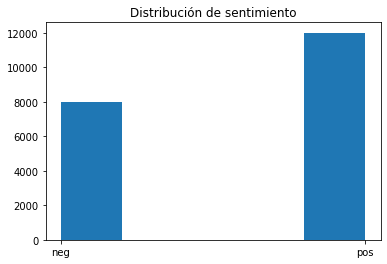

In [16]:
# Histograma (problema binario)
plt.hist(df_newamazon['sentiment_bilabel'], bins=5)
plt.title("Distribución de sentimiento")

Text(0.5, 1.0, 'Distribución de sentimiento')

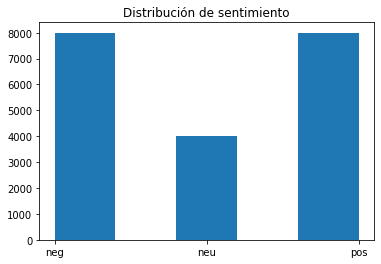

In [17]:
# Histograma (problema multiclase)
plt.hist(df_newamazon['sentiment_trilabel'], bins=5)
plt.title("Distribución de sentimiento")

In [18]:
# Visualizamos las primeras filas
df_newamazon.head(3)

,overall,reviewText,sentiment_trilabel,sentiment_bilabel
0,1.0,"Tumbleweed Connection raised Elton to his initial peak audibly with the hit single Country Comfort, and that legendary epic, Burn down the mission. It was the energy of that album that inspired the recording of 11-17-70, Live at the ANR Studios in New York City. In reality, this album was nothing but one long horrible noise. John's talents were wasted, with his vocals drowned in layers of instruments, which unfortunately destroyed the albums ambience. The eighteen minute version of burn down the mission became panned out to the point of very overdone. As much as I love listening to Elton's Music, this album was a rapid fall to failure. The modestly improved &quot;madman across the water&quot; and &quot;Honky chateau&quot;, were released in 1971 and 1972 respectively. but it would be the release of &quot;Don't shoot me, I'm only the piano player&quot;, and &quot;Good-bye yellow brick road&quot; in 1973, that would bring him back to his audible peak, and steer him well clear of this brief trench in his career.",neg,neg
1,1.0,Im not gonna review on this.. all i can say is that if you one of them trendy thugs that wear a rainbow colored fits & clothing (gay) and dance around in the middle of the streets (like a complete moron).. then go get this album.. If your a real rap listener and knows a definition of rap & Hip Hop.. avoid this album at all costs,neg,neg
2,1.0,"I bought this album because I went to a lyric site and their lyrics for a song on Absolution were insightful. Once I received the album I was consumed with disappointment. This world is suffering from the disease of delusion, religion is the opiate of the masses, and it is more destructive than heroin. The ignorance of musicians spouting their idiotic rhetoric, which perpetuates the myths that god exists and we have souls is sickening. Lyrics are a main component of music and musicians have to write lyrics that people can relate to in order to provide catharsis. Hopefully this band will cease to exist so intelligent artists will thrive in our culture and challenge the ignorance that infects everything.",neg,neg


In [19]:
# Las dimensiones del corpus df_newamazon no han variado con respecto al notebook anterior
print('Dimensiones del Corpus de df_newamazon: ', {lenCorpus(df_newamazon, 'reviewText')})

Dimensiones del Corpus de df_newamazon:  {159223}


### Procesado de los datos

In [20]:
# Función que realiza el preprocesado de los datos sobre la columna de un df
def preproccess_df(df, col_name):
    
    # Convierte el texto a minúsuculas
    df[col_name] = df[col_name].map(lambda x: x.lower())
    
    # Eliminar los espacions al principio y final 
    df[col_name] = df[col_name].map(lambda x: x.strip())
    
    # Reemplazamos el pipeline '|' por espacio
    df[col_name] = df[col_name].map(lambda x: x.replace('|', ' '))
    
    # Reemmplazamos &#34; ó &quot; (comillas dobles) por comillas simples
    df[col_name] = df[col_name].map(lambda x: x.replace('&#34;', "'" ))
    df[col_name] = df[col_name].map(lambda x: x.replace('&quot;', "'" ))
    
    # Reemmplazamo &#60; o &lt; por (<) y &#62; o &gt; por (>)
    df[col_name] = df[col_name].map(lambda x: x.replace('&#60;', "<" ))
    df[col_name] = df[col_name].map(lambda x: x.replace('&lt;',  "<" ))
    df[col_name] = df[col_name].map(lambda x: x.replace('&#62;', ">" ))
    df[col_name] = df[col_name].map(lambda x: x.replace('&gt;',  ">" ))
    
    # &amp;
    df[col_name] = df[col_name].map(lambda x: x.replace('&amp;',  "&" ))
    
    # &#8203; &#8211; &#8212; &#8216; &#8217; &#8220; &#8221; &#8226; &#8230; &#8482;
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8203;', "" ))
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8211;', "-" ))  # raya corta
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8212;', "-" ))  # raya larga
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8216;', "''" )) # comilla izquierda - citación
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8217;', "''" )) # comilla derecha - citación
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8220;', "''" )) # comillas de citación - arriba izquierda
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8221;', "''" )) # comillas de citación - arriba derecha
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8226;', "" ))   # viñeta - bullet
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8230;', "." ))  # puntos suspensivos
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8482;', "TM" )) # signo de marca registrada - trade mark
    
    return df


In [21]:
# Preprocesado del conjunto completo del dataframe df_newamazon
df_amazon_clean = preproccess_df(df_newamazon, 'reviewText')
df_amazon_clean.head(3)

,overall,reviewText,sentiment_trilabel,sentiment_bilabel
0,1.0,"tumbleweed connection raised elton to his initial peak audibly with the hit single country comfort, and that legendary epic, burn down the mission. it was the energy of that album that inspired the recording of 11-17-70, live at the anr studios in new york city. in reality, this album was nothing but one long horrible noise. john's talents were wasted, with his vocals drowned in layers of instruments, which unfortunately destroyed the albums ambience. the eighteen minute version of burn down the mission became panned out to the point of very overdone. as much as i love listening to elton's music, this album was a rapid fall to failure. the modestly improved 'madman across the water' and 'honky chateau', were released in 1971 and 1972 respectively. but it would be the release of 'don't shoot me, i'm only the piano player', and 'good-bye yellow brick road' in 1973, that would bring him back to his audible peak, and steer him well clear of this brief trench in his career.",neg,neg
1,1.0,im not gonna review on this.. all i can say is that if you one of them trendy thugs that wear a rainbow colored fits & clothing (gay) and dance around in the middle of the streets (like a complete moron).. then go get this album.. if your a real rap listener and knows a definition of rap & hip hop.. avoid this album at all costs,neg,neg
2,1.0,"i bought this album because i went to a lyric site and their lyrics for a song on absolution were insightful. once i received the album i was consumed with disappointment. this world is suffering from the disease of delusion, religion is the opiate of the masses, and it is more destructive than heroin. the ignorance of musicians spouting their idiotic rhetoric, which perpetuates the myths that god exists and we have souls is sickening. lyrics are a main component of music and musicians have to write lyrics that people can relate to in order to provide catharsis. hopefully this band will cease to exist so intelligent artists will thrive in our culture and challenge the ignorance that infects everything.",neg,neg


In [22]:
# Las dimensiones del corpus df_newamazon una vez preprocesado.
# Observamos que si ha disminuido con respecto al df inicial df_newamazon
print('Dimensiones del Corpus con preprocesado: ', {lenCorpus(df_amazon_clean, 'reviewText')})

Dimensiones del Corpus con preprocesado:  {140413}


In [23]:
# Guardamos el dataframe (by default index = True)
df_amazon_clean.to_pickle('df_amazon_clean.pkl')

In [24]:
# Comprobamos que al cargar el fichero pkl no hay diferencias
# Load pickled pandas object (or any object) from file.
df_newamazon_clean = pd.read_pickle('df_amazon_clean.pkl')

print(f'Dimensiones del dataframe df_newamazon_clean: ', df_newamazon_clean.shape)
print(f'Dimensiones del dataframe df_amazon_clean: ', df_amazon_clean.shape)

df_amazon_clean.equals(df_newamazon_clean)

Dimensiones del dataframe df_newamazon_clean:  (20000, 4)
Dimensiones del dataframe df_amazon_clean:  (20000, 4)


True

### Lemmatization

Técnica de normalización de textos que busca reducir las palabras a su raíz (lemma).

In [25]:
# Ruta del fichero en la que se encuentra el fichero para lemmatización en inglés
# Descargado de la URL https://github.com/michmech/lemmatization-lists
data_path = '../data'
lemmas_dict_file = 'lemmatization-en.txt'

In [26]:
# Función get_lemmas_dict 
def get_lemmas_dict(data_path, lemmas_dict_file):
    lemmas_dict = {}
    with open(os.path.join(data_path, lemmas_dict_file), 'r', encoding='utf-8') as f: 
        for line in f:
            (key, val) = line.split()
            lemmas_dict[str(val)] = key
    return lemmas_dict

In [27]:
# Obtenemos el diccionario de lemmas en inglés
lemmas_dict = get_lemmas_dict(data_path, lemmas_dict_file)
lemmas_dict

{'first': '\ufeff1',
 'tenth': '10',
 'hundredth': '100',
 'thousandth': '1000',
 'millionth': '1000000',
 'billionth': '1000000000',
 'eleventh': '11',
 'twelfth': '12',
 'thirteenth': '13',
 'fourteenth': '14',
 'fifteenth': '15',
 'sixteenth': '16',
 'seventeenth': '17',
 'eighteenth': '18',
 'nineteenth': '19',
 'second': '2',
 'twentieth': '20',
 'two-hundredth': '200',
 'twenty-first': '21',
 'twenty-second': '22',
 'twenty-third': '23',
 'twenty-fourth': '24',
 'twenty-fifth': '25',
 'twenty-sixth': '26',
 'twenty-seventh': '27',
 'twenty-eighth': '28',
 'twenty-ninth': '29',
 'third': '3',
 'thirtieth': '30',
 'three-hundredth': '300',
 'thirty-first': '31',
 'thirty-second': '32',
 'thirty-third': '33',
 'thirty-fourth': '34',
 'thirty-fifth': '35',
 'thirty-sixth': '36',
 'thirty-seventh': '37',
 'thirty-eighth': '38',
 'thirty-ninth': '39',
 'fourth': '4',
 'fortieth': '40',
 'four-hundredth': '400',
 'forty-first': '41',
 'forty-second': '42',
 'forty-third': '43',
 'forty-

In [28]:
# Comprobamos el par token-lemma con el primer registro
print('{0:15}{1:10}'.format('Token' ,'Lemma'))
for word in df_newamazon['reviewText'][250].split():
    print('{0:15}{1:10}'.format(word, lemmas_dict.get(word, word)))

Token          Lemma     
i              i         
mean           mean      
what           what      
was            be        
all            all       
said           say       
here           here      
except         except    
a              a         
mention        mention   
of             of        
just           just      
about          about     
every          every     
popular        popular   
celebrity,     celebrity,
singer,        singer,   
rapper         rapper    
and            and       
samples        sample    
of             of        
their          their     
lyrics         lyric     
and            and       
every          every     
song           song      
featured       feature   
some           some      
other          other     
artist.        artist.   
so             so        
there          there     
was            be        
trully         trully    
no             no        
orginality     orginality
or             or        
provocative 

Por ejemplo en el tweet 250 el lemma aplicado corresponde a la segunda columna:

    Palabras       Lemmas

    was            be
    said           say
    samples        sample
    lyrics         lyric
    featured       feature  
    sparked        spark
    got            get 


In [29]:
# Aplicamos la lemmatización sobre el df df_amazon_clean ya preprocesado
df_amazon_clean['reviewText']= df_amazon_clean['reviewText'].apply(lambda x: ' '.join([lemmas_dict.get(word, word) for word in x.split()]))

In [30]:
# Guardamos el dataframe con el preprocesado y limpio
df_amazon_clean.to_pickle('df_amazon_cleanlemma.pkl')

In [31]:
# Comprobamos que al cargar el fichero pkl no hay diferencias
# Load pickled pandas object (or any object) from file.
df_newamazon_cleanlemma = pd.read_pickle('df_amazon_cleanlemma.pkl')

print(f'Dimensiones del dataframe df_newamazon_cleanlemma: ', df_newamazon_cleanlemma.shape)
print(f'Dimensiones del dataframe df_amazon_clean: ', df_amazon_clean.shape)

df_amazon_clean.equals(df_newamazon_cleanlemma)

Dimensiones del dataframe df_newamazon_cleanlemma:  (20000, 4)
Dimensiones del dataframe df_amazon_clean:  (20000, 4)


True

### División del dataframe en train y test  (Con preprocesado de los datos + Lemmatization)

Dividimos el dataframe airbnb_data en dos conjuntos, uno para training (entrenamiento) y otro para testing utizando:

    train_test_split = Split arrays or matrices into random train and test subsets con los parámetros:
      - shuffle = True   (orden aleatorio)
      - random_state = 42 (repetitibilidad de los datos) Using an int will produce the same results across different calls.
      - test_size = Represent the proportion of the dataset df_train 75% to include in the test split.
      - stratify: obtener unas muestras distribuidas según la etiqueta y = df_amazon_clean['sentiment_trilabel']

In [32]:
# División del df df_amazon_clean en train 75% y test 25%  balanceada respecto a sentiment_multilabel
# Dataframe_ df_amazon_clean al cual se ha aplicado un preprocesado y lemmatización de un diccionario en inglés
amazon_train, amazon_test = train_test_split(
    df_amazon_clean,
    train_size = 0.75,
    test_size=0.25, 
    random_state=42,    
    shuffle=True,       
    stratify = df_amazon_clean['sentiment_trilabel']  
)

print(f'Datos entrenamiento: {amazon_train.shape}')
print(f'Datos test:  {amazon_test.shape}')

Datos entrenamiento: (15000, 4)
Datos test:  (5000, 4)


In [33]:
amazon_train.iloc[:3]

,overall,reviewText,sentiment_trilabel,sentiment_bilabel
2606,3.0,i wouldn't say this be waylon jennings well record. but it be very good. my favorite song on here be waymore's blue and i've be a long time leaving. i have a few waylon album before i get this. and i didn't get this until 1981. the big song be be you sure hank do it this way which be one of my favorite waylon songs. it have bob will be still the king. he doe a version of i recall a gypsy woman. and i think he do the ﻿1 version of the door be always open on here. this be one of that album that every song be good.,neu,pos
14234,5.0,"so easy to use and fast 1 2 reading. i love that it have ear and forehead readings, because i always want to double check my temperatures. i have 3 little guy under age 5 and they have period be they get fever after immunizations, teething, and infections. there be two button f1 to scan the forehead from one side to another and f2 for scan the ear. infrared reading allow me to take a temp without even touch or wake the kids.",pos,pos
12250,3.0,"this one be just okay, it doesn't really stimulate the clitoris a i hope it would. would not buy again.",neu,pos


In [34]:
# Verificamos que las muestras están balanceadas en train para el problema multiclase
amazon_train['sentiment_trilabel'].value_counts()

neg    6000
pos    6000
neu    3000
Name: sentiment_trilabel, dtype: int64

In [35]:
# Verificamos que las muestras están balanceadas en train para el problema binario
amazon_train['sentiment_bilabel'].value_counts()

pos    9000
neg    6000
Name: sentiment_bilabel, dtype: int64

### Extracción de features

CountVectorizer

    Convierte una colleción de documentos en una matriz de documentos-palabras. La codificación se realiza, por tanto, a nivel de documento, en lugar de a nivel de token.

    Al ser un modelo de bag-of-words, no se codifica la información relativa a la posición de los tokens ni su contexto, solo información a si aparecen y su frecuencia.

TF-IDF Vectorizer

    Term Frequency - Inverse Document Frequency es una medida de feature weighting que expresa lo relevante que es una palabra en un documento, siendo este documento parte de un corpus.


Parámetros:

    max_df = 0.95 --> Filtramos el 5% de las palabras que más se repiten
    min_df = 5    --> Eliminar palabras que no aparezcan al menos 5 veces
    max_features = 2000 --> Filtramos el nº de características a 2500
    ngram_range = (1, 2) --> trabajamos con palabras y bigramas
    stop_words

In [36]:
# CountVectorizer simple
cv_simple = CountVectorizer()
X_train_cv_simple = cv_simple.fit_transform(amazon_train['reviewText'])
X_test_cv_simple = cv_simple.transform(amazon_test['reviewText'])

# CountVectorizer simple + stop_words
cv_simple_sw = CountVectorizer(stop_words='english')
X_train_cv_simple_sw = cv_simple_sw.fit_transform(amazon_train['reviewText'])
X_test_cv_simple_sw  = cv_simple_sw.transform(amazon_test['reviewText'])

# CountVectorizer filter features
cv_complex = CountVectorizer(ngram_range=(1, 2), max_features=2000, max_df=0.95, min_df=5)
X_train_cv_complex = cv_complex.fit_transform(amazon_train['reviewText'])
X_test_cv_complex = cv_complex.transform(amazon_test['reviewText'])

# CountVectorizer filter features +  stop_words
cv_complex_sw = CountVectorizer(ngram_range=(1, 2), max_features=2000, max_df=0.95, min_df=5, stop_words='english')
X_train_cv_complex_sw = cv_complex_sw.fit_transform(amazon_train['reviewText'])
X_test_cv_complex_sw = cv_complex_sw.transform(amazon_test['reviewText'])

# TfIdfVectorizer simple
tfidf_simple = TfidfVectorizer()
X_train_tfidf_simple = tfidf_simple.fit_transform(amazon_train['reviewText'])
X_test_tfidf_simple = tfidf_simple.transform(amazon_test['reviewText'])

# TfIdfVectorizer simple + stop_words
tfidf_simple_sw = TfidfVectorizer(stop_words='english')
X_train_tfidf_simple_sw = tfidf_simple_sw.fit_transform(amazon_train['reviewText'])
X_test_tfidf_simple_sw = tfidf_simple_sw.transform(amazon_test['reviewText'])

# TfIdfVectorizer complejo (filter features)
tfidf_complex = TfidfVectorizer(ngram_range=(1, 2), max_features=2000, max_df=0.95, min_df=5)
X_train_tfidf_complex = tfidf_complex.fit_transform(amazon_train['reviewText'])
X_test_tfidf_complex = tfidf_complex.transform(amazon_test['reviewText'])

# TfIdfVectorizer complejo (filter features) + stop_words
tfidf_complex_sw = TfidfVectorizer(ngram_range=(1, 2), max_features=2000, max_df=0.95, min_df=5, stop_words='english')
X_train_tfidf_complex_sw = tfidf_complex_sw.fit_transform(amazon_train['reviewText'])
X_test_tfidf_complex_sw = tfidf_complex_sw.transform(amazon_test['reviewText'])

In [37]:
print('Dimensiones del vocabulario cv_simple:       ', {len(cv_simple.vocabulary_)})
print('Dimensiones del vocabulario cv_simple_sw:    ', {len(cv_simple_sw.vocabulary_)})
print('Dimensiones del vocabulario cv_complex:      ', {len(cv_complex.vocabulary_)})
print('Dimensiones del vocabulario cv_complex_sw:   ', {len(cv_complex_sw.vocabulary_)})
print('Dimensiones del vocabulario tfidf_simple:    ', {len(tfidf_simple.vocabulary_)})
print('Dimensiones del vocabulario tfidf_simple_sw: ', {len(tfidf_simple_sw.vocabulary_)})
print('Dimensiones del vocabulario tfidf_complex:   ', {len(tfidf_complex.vocabulary_)})
print('Dimensiones del vocabulario tfidf_complex_sw:', {len(tfidf_complex_sw.vocabulary_)})

Dimensiones del vocabulario cv_simple:        {39378}
Dimensiones del vocabulario cv_simple_sw:     {39071}
Dimensiones del vocabulario cv_complex:       {2000}
Dimensiones del vocabulario cv_complex_sw:    {2000}
Dimensiones del vocabulario tfidf_simple:     {39378}
Dimensiones del vocabulario tfidf_simple_sw:  {39071}
Dimensiones del vocabulario tfidf_complex:    {2000}
Dimensiones del vocabulario tfidf_complex_sw: {2000}


Observamos que las dimensiones del vocabulario han disminuido con respecto al notebook anterior al aplicar un preprocesado además de la lemmatization en los vocabularios en los cuales no se aplica filtrado de features (max_features).

### TF-IDF scores en train y test sets

In [38]:
print(f'TF-IFD Simple scores train: {X_train_tfidf_simple.shape}')
print(f'TF-IFD Simple scores test:  {X_test_tfidf_simple.shape}')

TF-IFD Simple scores train: (15000, 39378)
TF-IFD Simple scores test:  (5000, 39378)


In [39]:
print(f'TF-IFD Complex scores train: {X_train_tfidf_complex.shape}')
print(f'TF-IFD Complex scores test:  {X_test_tfidf_complex.shape}')

TF-IFD Complex scores train: (15000, 2000)
TF-IFD Complex scores test:  (5000, 2000)


### Score IDF de algunas palabras

In [40]:
# Diccionario con las 2000 features que hemos extraido pj de tfidf_complex
vocab_idfcomplex = dict(zip(tfidf_complex.get_feature_names(), tfidf_complex.idf_))
print('Dimensiones del vocabulario tfidf_complex:   ', {len(vocab_idfcomplex)})
vocab_idfcomplex

Dimensiones del vocabulario tfidf_complex:    {2000}


{'10': 4.057674341716622,
 '100': 5.1187039192356885,
 '11': 5.332668415790902,
 '12': 4.939118342260608,
 '13': 5.611925838583431,
 '15': 4.973965073590777,
 '16': 5.8451875200632255,
 '20': 4.798760984565686,
 '25': 5.6886184593716855,
 '30': 4.9810825413596405,
 '40': 5.3688480723684044,
 '50': 4.757938990045431,
 '50 cent': 5.915391778736474,
 '70': 5.779590237577413,
 '80': 5.528275809296506,
 '90': 5.7483376940733075,
 'able': 4.3582045566462515,
 'able to': 4.389335475241425,
 'about': 2.705281532272412,
 'about it': 5.131075211038235,
 'about the': 4.478145090442656,
 'about this': 4.8107371756124016,
 'above': 5.190922127047488,
 'absolutely': 4.984660362707524,
 'accurate': 5.497878332112135,
 'acoustic': 5.756059740167219,
 'across': 5.5344677795444275,
 'act': 5.681398211398198,
 'actual': 5.47420858802623,
 'actually': 3.86477067559213,
 'add': 4.220610546413441,
 'addition': 5.598592307713966,
 'adjust': 5.273537892564079,
 'admit': 5.605236850432634,
 'after': 2.86913923

In [41]:
# Ordenamos el diccionario por valores decrecientes value
sortvocab_idfcomplex = sorted(vocab_idfcomplex.items(), key=operator.itemgetter(1),  reverse=True)
sortvocab_idfcomplex

[('fish oil', 7.150136241729164),
 ('omega', 7.11936458306241),
 ('mg', 6.724051846418264),
 ('shaver', 6.521527582306789),
 ('elton', 6.441484874633253),
 ('rack', 6.4262174025024645),
 ('ja', 6.396364439352784),
 ('the watch', 6.259163317839299),
 ('bolt', 6.2214229898564515),
 ('dre', 6.2214229898564515),
 ('cushion', 6.197031536732292),
 ('hat', 6.173220888038574),
 ('scale', 6.173220888038574),
 ('michael', 6.161524848275382),
 ('the knife', 6.161524848275382),
 ('frame', 6.12723577479675),
 ('punk', 6.12723577479675),
 ('nas', 6.116062474198626),
 ('slim', 6.09408356747985),
 ('fish', 6.083272651375634),
 ('paul', 6.083272651375634),
 ('holster', 6.072577362258887),
 ('shower', 6.06199525292835),
 ('rush', 6.051523953061054),
 ('rule', 6.041161166025508),
 ('spray', 6.041161166025508),
 ('the unit', 6.030904665858318),
 ('this knife', 6.030904665858318),
 ('thumb', 6.0207522943943),
 ('sugar', 6.010701958540799),
 ('nose', 6.000751627687631),
 ('phone', 6.000751627687631),
 ('las

In [42]:
# Top 10 de los palabras con mayor  IDF
sortvocab_idfcomplex[0:10]

[('fish oil', 7.150136241729164),
 ('omega', 7.11936458306241),
 ('mg', 6.724051846418264),
 ('shaver', 6.521527582306789),
 ('elton', 6.441484874633253),
 ('rack', 6.4262174025024645),
 ('ja', 6.396364439352784),
 ('the watch', 6.259163317839299),
 ('bolt', 6.2214229898564515),
 ('dre', 6.2214229898564515)]

In [43]:
# Top 10 de los palabras con menor  IDF  (nuestro diccionario está compuesto por 2000 features)
sortvocab_idfcomplex[1990:2000]

[('but', 1.5946362816434947),
 ('have', 1.580480575017249),
 ('for', 1.5692278652234974),
 ('of', 1.5057941944911017),
 ('it', 1.3473572085016354),
 ('to', 1.3080421512754503),
 ('this', 1.2623842633342226),
 ('and', 1.2210458929293764),
 ('the', 1.1525187876362202),
 ('be', 1.1261591279720675)]

### Palabras con el TF-IDF en alguna review

In [44]:
# Seleccionamos aleatoriamente una review para extraer las palabras junto con su TF-IDF 
i = random.randint(0, len(amazon_train))
print('ID: {}'.format(i))
print('SentimentLabel: {}'.format(amazon_train['sentiment_bilabel'].iloc[i]))
print('ReviewText: {}'.format(amazon_train['reviewText'].iloc[i]))

ID: 9
SentimentLabel: pos
ReviewText: this be the 3 pair of this i've own (they will wear out if constantly used) and i have notice small difference in all of them the big be the introduction of l.e.d. lighting, a big improvement in battery life and focue. next be the reduction of pad in the headband forehead area. i add some pad & that help & when this wear out i will buy again.


In [45]:
# Aplicamos la muestra obtenida con está técnica de extracción de features tfidf_complex
doc_vector = X_train_tfidf_complex[i]
df_tfidfcomplex = pd.DataFrame(doc_vector.T.todense(), index=tfidf_complex.get_feature_names(), columns=['tfidf'])
df_tfidfcomplex = df_tfidfcomplex[df_tfidfcomplex['tfidf'] > 0]

# Top n
top_n = 10
print('Top {} words with highest TF_IDF Nº {}:\n{}'.format(top_n, i, df_tfidfcomplex.sort_values(by=["tfidf"], ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF Nº {}:\n{}'.format(top_n, i, df_tfidfcomplex.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF Nº 9:
              tfidf
pad        0.343300
be the     0.282202
big        0.222144
wear       0.216587
of         0.200343
the        0.191675
they will  0.183881
the big    0.175249
in all     0.171508
will       0.169551

Top 10 words with lowest TF_IDF Nº 9:
            tfidf
buy      0.086631
when     0.084309
in the   0.082062
and      0.081229
this be  0.081067
all      0.076423
if       0.073825
they     0.072371
that     0.055718
have     0.052570


### 𝜒²  scores

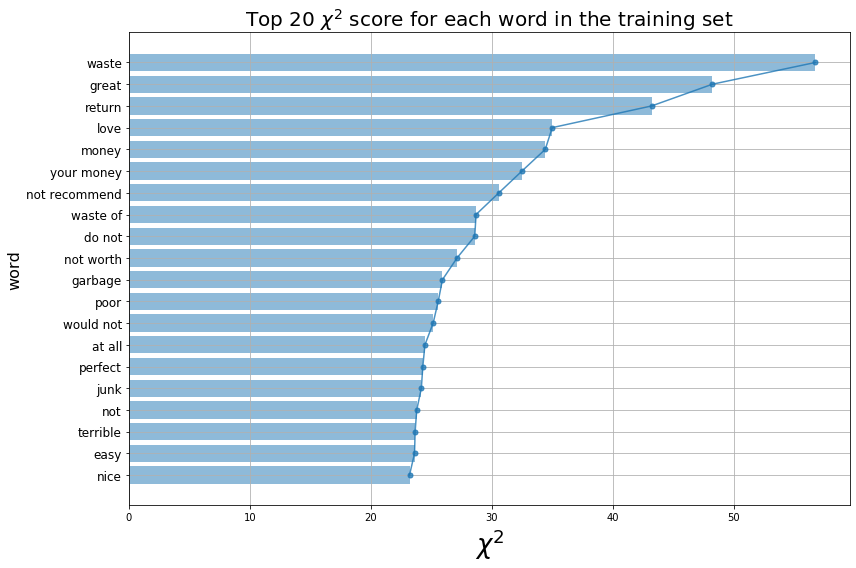

In [46]:
# Compute the chi-squared score for each word in the training set and show the values (tfidf_complex)
i = 20 

chi2score = chi2(X_train_tfidf_complex, amazon_train['sentiment_bilabel'])[0]
scores = list(zip(tfidf_complex.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Muchas de estas palabras, también se incluían en el notebook anterior, como por ejemplo 

        waste
        great
        money
        love
        return
        nor recommended


### Entrenamiento - Modelo LogisticRegression para el problema de clasificación binaria

In [47]:
# Para el problema de clasificación binaria aplicamos el modelo LogisticRegression
# The 'newton-cg', 'sag', and 'lbfgs' solvers support only L2 regularization with primal formulation, or no regularization
lr_cv_simple        = LogisticRegression(solver='lbfgs')  # obtengo mejores resultados
lr_cv_simple_sw     = LogisticRegression(solver='lbfgs')
lr_cv_complex       = LogisticRegression(solver='lbfgs')
lr_cv_complex_sw    = LogisticRegression(solver='lbfgs')
lr_tfidf_simple     = LogisticRegression(solver='lbfgs')
lr_tfidf_simple_sw  = LogisticRegression(solver='lbfgs')
lr_tfidf_complex    = LogisticRegression(solver='lbfgs')
lr_tfidf_complex_sw = LogisticRegression(solver='lbfgs')

In [48]:
# Función que realiza el entrenamiento en training y predice test con algunas métricas (matriz de confusión, accuracy)
def  model_training(lr_model, X_train, y_train, X_test, y_test):
    
    lr_model.fit(X_train, y_train)
    y_predict = lr_model.predict(X_test)
   
    print('Modelo: ', {lr_model})
    print(confusion_matrix(y_test, y_predict))
    print(classification_report(y_test, y_predict))
    print('Accuracy score:{}'.format(accuracy_score(y_test, y_predict)))
    
    plot_confusion_matrix(confusion_matrix(y_test, y_predict))
    

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1358  642]
 [ 552 2448]]
              precision    recall  f1-score   support

         neg       0.71      0.68      0.69      2000
         pos       0.79      0.82      0.80      3000

    accuracy                           0.76      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.76      0.76      0.76      5000

Accuracy score:0.7612


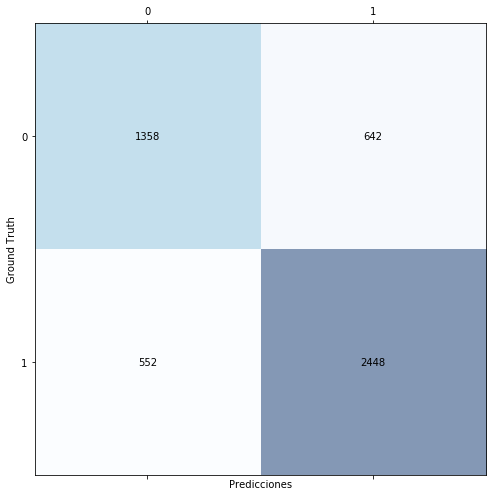

In [49]:
# Modelo 1. CountVectorizer simple - LogisticRegression
model_training(lr_cv_simple, X_train_cv_simple,  amazon_train['sentiment_bilabel'], 
                             X_test_cv_simple, amazon_test['sentiment_bilabel'])

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1333  667]
 [ 555 2445]]
              precision    recall  f1-score   support

         neg       0.71      0.67      0.69      2000
         pos       0.79      0.81      0.80      3000

    accuracy                           0.76      5000
   macro avg       0.75      0.74      0.74      5000
weighted avg       0.75      0.76      0.75      5000

Accuracy score:0.7556


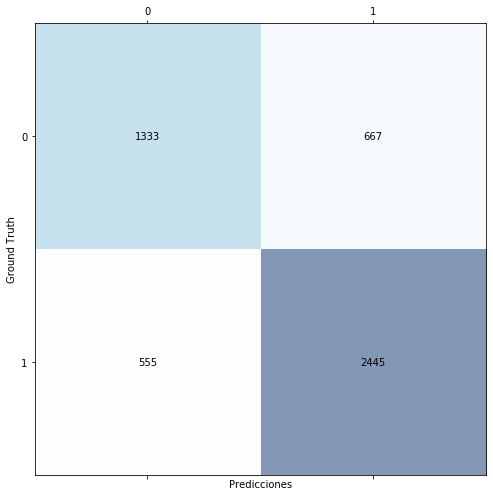

In [50]:
# Modelo 2. CountVectorizer simple + stop_words - LogisticRegression
model_training(lr_cv_simple_sw, X_train_cv_simple_sw,  amazon_train['sentiment_bilabel'], 
                                X_test_cv_simple_sw, amazon_test['sentiment_bilabel'])

                    CountVectorizer simple                    CountVectorizer simple con stop_words
    
    M.confusión     [[1358  642]   Falsos negativos: 642      [[1333  667]   Falsos negativos: 667       
                     [ 552 2448]]  Falsos positivos: 552       [ 555 2445]]  Falsos positivos: 555
    
    Accuracy        0.7612                                    0.7556


    El mejor resultado obtenido es el modelo sin aplicar stop_words, tanto en accuracy como en falsos positivos y negativos. 
    
    Accuracy Notebook anterior sin procesado ni lematización de los datos:
                    0.775                                     0.7592

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1344  656]
 [ 534 2466]]
              precision    recall  f1-score   support

         neg       0.72      0.67      0.69      2000
         pos       0.79      0.82      0.81      3000

    accuracy                           0.76      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.76      0.76      0.76      5000

Accuracy score:0.762


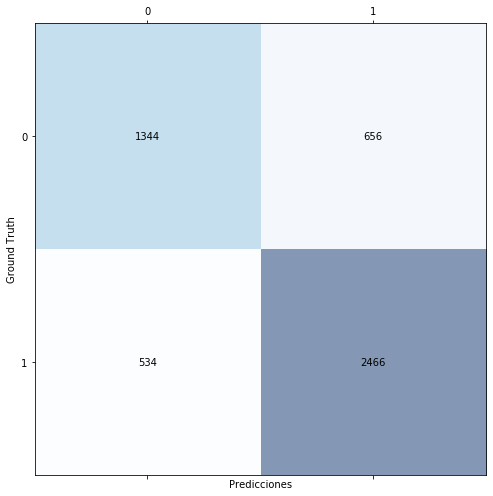

In [51]:
# Modelo 3. CountVectorizer filter features - LogisticRegression
model_training(lr_cv_complex, X_train_cv_complex,  amazon_train['sentiment_bilabel'], 
                              X_test_cv_complex, amazon_test['sentiment_bilabel'])

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1309  691]
 [ 556 2444]]
              precision    recall  f1-score   support

         neg       0.70      0.65      0.68      2000
         pos       0.78      0.81      0.80      3000

    accuracy                           0.75      5000
   macro avg       0.74      0.73      0.74      5000
weighted avg       0.75      0.75      0.75      5000

Accuracy score:0.7506


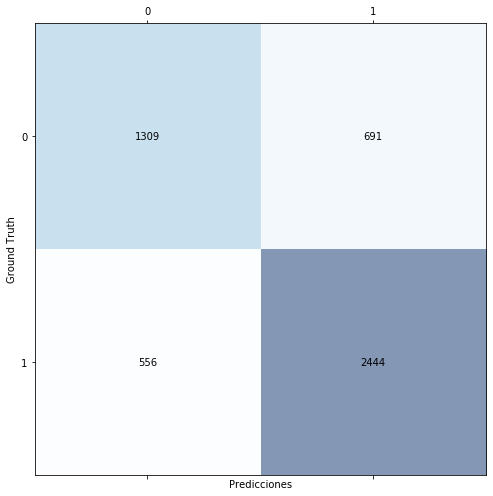

In [52]:
# Modelo 4. CountVectorizer filter features + stop_words - LogisticRegression
model_training(lr_cv_complex_sw, X_train_cv_complex_sw,  amazon_train['sentiment_bilabel'], 
                                 X_test_cv_complex_sw, amazon_test['sentiment_bilabel'])

                    CountVectorizer filter features           CountVectorizer filter features con stop_words

    M.confusión     [[1344  656]   Falsos negativos: 656      [[1309  691]   Falsos negativos: 691       
                     [ 534 2466]]  Falsos positivos: 534       [ 556 2444]]  Falsos positivos: 556

    Accuracy        0.762                                     0.7506
    
    Son modelos con resultados similares, algo mejor el primer modelo sin aplicar stop_words.
    
    Accuracy Notebook anterior sin procesado ni lematización de los datos:
                    0.7652                                    0.7594

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1253  747]
 [ 383 2617]]
              precision    recall  f1-score   support

         neg       0.77      0.63      0.69      2000
         pos       0.78      0.87      0.82      3000

    accuracy                           0.77      5000
   macro avg       0.77      0.75      0.76      5000
weighted avg       0.77      0.77      0.77      5000

Accuracy score:0.774


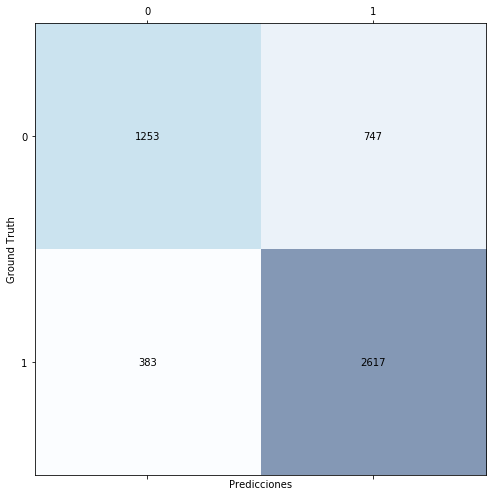

In [53]:
# Modelo 5. TfIdfVectorizer simple - - LogisticRegression
model_training(lr_tfidf_simple, X_train_tfidf_simple,  amazon_train['sentiment_bilabel'], 
                                X_test_tfidf_simple, amazon_test['sentiment_bilabel'])

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1226  774]
 [ 408 2592]]
              precision    recall  f1-score   support

         neg       0.75      0.61      0.67      2000
         pos       0.77      0.86      0.81      3000

    accuracy                           0.76      5000
   macro avg       0.76      0.74      0.74      5000
weighted avg       0.76      0.76      0.76      5000

Accuracy score:0.7636


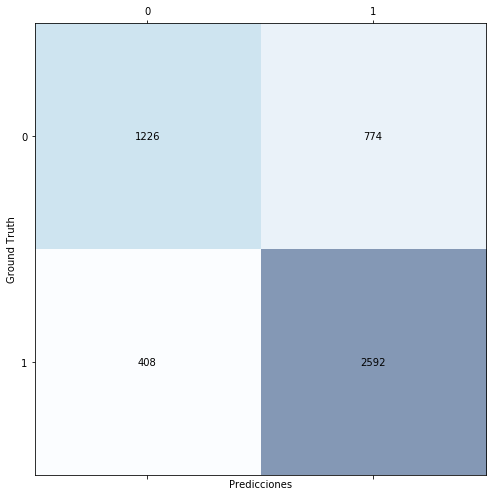

In [54]:
# Modelo 6. TfIdfVectorizer simple +  stop_words - - LogisticRegression
model_training(lr_tfidf_simple_sw, X_train_tfidf_simple_sw,  amazon_train['sentiment_bilabel'], 
                                   X_test_tfidf_simple_sw, amazon_test['sentiment_bilabel'])

                    TfidfVectorizer simple                    TfidfVectorizer simple con stop_words

    M.confusión     [[1253  747]   Falsos negativos: 747      [[1226  774]   Falsos negativos: 774       
                     [ 383 2617]]  Falsos positivos: 383       [ 408 2592]]  Falsos positivos: 408 

    Accuracy        0.774                                     0.7636
    
    Son modelos con resultados similares, algo mejor el primer modelo sin aplicar stop_words
    
    Accuracy Notebook anterior sin procesado ni lematización de los datos:
                    0.7786                                    0.7718

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1294  706]
 [ 419 2581]]
              precision    recall  f1-score   support

         neg       0.76      0.65      0.70      2000
         pos       0.79      0.86      0.82      3000

    accuracy                           0.78      5000
   macro avg       0.77      0.75      0.76      5000
weighted avg       0.77      0.78      0.77      5000

Accuracy score:0.775


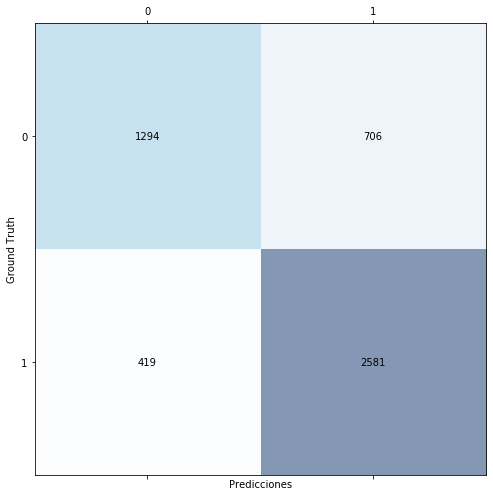

In [55]:
# Modelo 7. TfIdfVectorizer filter features - - LogisticRegression
model_training(lr_tfidf_complex, X_train_tfidf_complex,  amazon_train['sentiment_bilabel'], 
                                 X_test_tfidf_complex, amazon_test['sentiment_bilabel'])

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1268  732]
 [ 454 2546]]
              precision    recall  f1-score   support

         neg       0.74      0.63      0.68      2000
         pos       0.78      0.85      0.81      3000

    accuracy                           0.76      5000
   macro avg       0.76      0.74      0.75      5000
weighted avg       0.76      0.76      0.76      5000

Accuracy score:0.7628


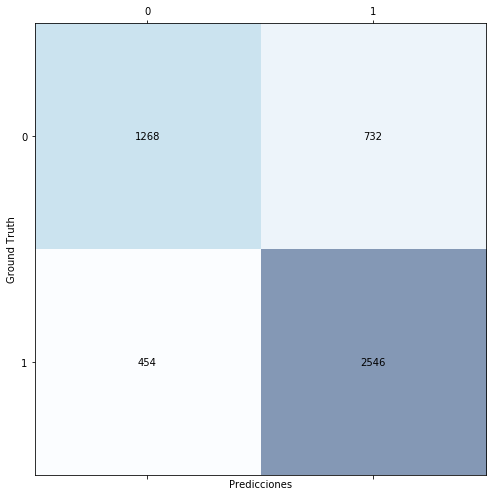

In [56]:
# Modelo 8. TfIdfVectorizer filter features + stop_words - - LogisticRegression
model_training(lr_tfidf_complex_sw, X_train_tfidf_complex_sw,  amazon_train['sentiment_bilabel'], 
                                    X_test_tfidf_complex_sw, amazon_test['sentiment_bilabel'])

                    TfidfVectorizer filter features           TfidfVectorizer filter features con stop_words

    M.confusión     [[1294  706]   Falsos negativos: 706      [[1268  732]   Falsos negativos: 732       
                     [ 419 2581]]  Falsos positivos: 419       [ 454 2546]]  Falsos positivos: 454 

    Accuracy        0.775                                     0.7628
    
    En este caso el mejor resultado es el primer modelo sin stop_words tanto en accuracy como en falsos negativos y falsos positivos.
    
    Accuracy Notebook anterior sin procesado ni lematización de los datos:
                    0.7836                                    0.7628

### Predicciones 

In [57]:
# Función que predice el analísis de sentimiento según el review de un dataframe
def predict_review_sentiment(df, review_index, col_name, col_label,  model, cv):
    print('Actual sentiment: {}'.format(df.iloc[review_index][col_label]))
    r = df.iloc[review_index][col_name]
    print('Prediction: {}'.format(model.predict(cv.transform([r]))))

In [58]:
# Aplicamos esta predicción sobre el modelo con mejores resultados TfidfVectorizer filter features sin aplicar stop_words
for i in random.sample(range(0, len(df_amazon_clean)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(df_amazon_clean, i, 'reviewText', 'sentiment_bilabel', lr_tfidf_complex, tfidf_complex)


Review no. 5518
Actual sentiment: neg
Prediction: ['neg']

Review no. 15777
Actual sentiment: neg
Prediction: ['pos']

Review no. 7824
Actual sentiment: pos
Prediction: ['neg']

Review no. 11025
Actual sentiment: neg
Prediction: ['pos']

Review no. 9752
Actual sentiment: pos
Prediction: ['pos']


In [59]:
# Aplicamos esta predicción sobre el modelo con mejores resultados TfidfVectorizer simple sin aplicar stop_words
for i in random.sample(range(0, len(df_amazon_clean)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(df_amazon_clean, i, 'reviewText', 'sentiment_bilabel', lr_tfidf_simple, tfidf_simple)


Review no. 9801
Actual sentiment: pos
Prediction: ['pos']

Review no. 16340
Actual sentiment: neg
Prediction: ['neg']

Review no. 6784
Actual sentiment: neg
Prediction: ['neg']

Review no. 19683
Actual sentiment: pos
Prediction: ['pos']

Review no. 540
Actual sentiment: neg
Prediction: ['neg']


Observamos que en la clasificación binario, algunas predicciones no han sido las esperadas en las Reviews no. 15777, 7824, 11025

### Conclusiones para el problema de clasificación binaria

Aplicando estas técnicas para la extracción de carácterísticas
    
    CountVectorizer simple
    CountVectorizer filter features
    TfidfVectorizer simple
    TfidfVectorizer filter features
    
y sus combinaciones con stop_words junto con un modelo  LogisticRegression para el problema de regresión binario.

Concluimos que el mejor resultado corresponde a la cuarta técnica:
    
    "TfidfVectorizer filter features" sin stop_words (accurary en test 77.5%) pero no mejora el resultado del notebook 
    anterior en el que no se ha aplicado ningún tratamiento sobre los datos  (accuracy en test 78.36%)

### Entrenamiento - Modelo Random Forest para el problema de clasificación multiclase

In [60]:
# Función que entrena el modelo Random Forest y obtiene hiperparámetro óptimo max_depth
# y calcula su score tanto en train como en test
def optimal_rfmodel (nmax, X_train, y_train, X_test, y_test):
    maxDepth = range(1,nmax)
    tuned_parameters = {'max_depth': maxDepth}

    grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
    grid.fit(X_train, y_train)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))

    scores = np.array(grid.cv_results_['mean_test_score'])
    plt.plot(maxDepth,scores,'-o')
    plt.xlabel('max_depth')
    plt.ylabel('10-fold ACC')

    plt.show()
    
    maxDepthOptimo = grid.best_params_['max_depth']
    rdModel = RandomForestClassifier(max_depth=maxDepthOptimo,
                                 n_estimators=200,max_features='sqrt').fit(X_train, y_train)

    print("Train: ",rdModel.score(X_train, y_train))
    print("Test:  ", rdModel.score(X_test, y_test))

best mean cross-validation score: 0.627
best parameters: {'max_depth': 14}


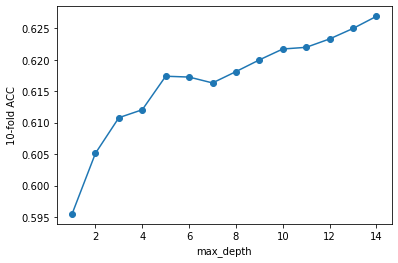

Train:  0.7117333333333333
Test:   0.6194


In [61]:
# Probaremos con las técnicas en las que hemos aplicado filtrado de features 
# Modelo 1. CountVectorizer filter features 
optimal_rfmodel (15, X_train_cv_complex, amazon_train['sentiment_trilabel'], 
                     X_test_cv_complex, amazon_test['sentiment_trilabel'])

In [62]:
# Probamos con otros valores de max_depth y optamos por el valor a 8
rdModel = RandomForestClassifier(max_depth=8,
                                 n_estimators=200,max_features='sqrt').fit(X_train_cv_complex,amazon_train['sentiment_trilabel'])

print("Train: ",rdModel.score(X_train_cv_complex, amazon_train['sentiment_trilabel']))
print("Test: ", rdModel.score(X_test_cv_complex, amazon_test['sentiment_trilabel']))

Train:  0.647
Test:  0.6092


    Con el max_depth óptimo = 14 (The maximum depth of the tree) se obtiene el siguiente resultado:

        71.17% Train
        61.94% Test

    La profundidad del árbol es muy elevada para este resultados.
    Probamos con max_depth 8 (64.7% Train y 61.94% Test), y consideramos este valor como bueno ya que de este modo simpli-
    ficaríamos la complejidad del modelo.
    
    Accuracy Notebook anterior sin procesado ni lematización de los datos 65.82% Train y 62.32% Test con max_depth = 8

best mean cross-validation score: 0.616
best parameters: {'max_depth': 14}


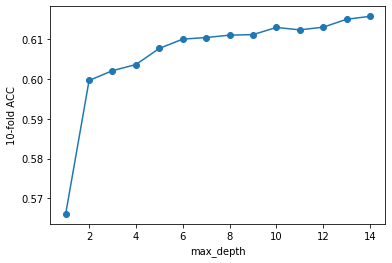

Train:  0.6736
Test:   0.619


In [63]:
# Modelo 2. CountVectorizer filter features  + stop_words
optimal_rfmodel (15, X_train_cv_complex_sw, amazon_train['sentiment_trilabel'], 
                     X_test_cv_complex_sw, amazon_test['sentiment_trilabel'])

In [64]:
# Probamos con otros valores de max_depth pj para el valor a 8
rdModel2 = RandomForestClassifier(max_depth=8,
                                 n_estimators=200,max_features='sqrt').fit(X_train_cv_complex_sw,amazon_train['sentiment_trilabel'])

print("Train: ",rdModel2.score(X_train_cv_complex_sw, amazon_train['sentiment_trilabel']))
print("Test: ", rdModel2.score(X_test_cv_complex_sw, amazon_test['sentiment_trilabel']))

Train:  0.6334
Test:  0.6108


                    CountVectorizer filter features           CountVectorizer filter features con stop_words

    max_depth         14     Noteb0        8    Noteb0          14     Noteb0       8      Noteb0
    Train            71.17%  71.76%      64.70  65.82%         67.36%  67.15%     63.34%   63.06%
    Test             61.94%  62.22%      60.92% 62.32%         61.90%  61.62%     61.08%   60.02%   
    
    No son buenos resultados pero quiza optara por el primer modelo aunque exista overfitting
    CountVectorizer filter features sin stop_words con max_depth a 8 + con un score de 61% para test y 65% aprox. para train pero no mejoramos el resultado del notebook anterior (66% train y 62% test).

best mean cross-validation score: 0.625
best parameters: {'max_depth': 14}


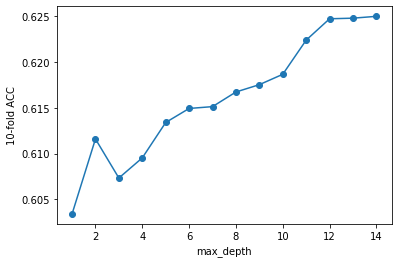

Train:  0.7182666666666667
Test:   0.6218


In [65]:
# Modelo 3. Tfidf filter features  
optimal_rfmodel (15, X_train_tfidf_complex, amazon_train['sentiment_trilabel'], 
                     X_test_tfidf_complex, amazon_test['sentiment_trilabel'])

In [66]:
# Probamos con otros valores de max_depth pj para el valor a 8
rdModel3 = RandomForestClassifier(max_depth=8,
                                 n_estimators=200,max_features='sqrt').fit(X_train_tfidf_complex,amazon_train['sentiment_trilabel'])

print("Train: ",rdModel3.score(X_train_tfidf_complex, amazon_train['sentiment_trilabel']))
print("Test: ", rdModel3.score(X_test_tfidf_complex, amazon_test['sentiment_trilabel']))

Train:  0.6518666666666667
Test:  0.6092


best mean cross-validation score: 0.617
best parameters: {'max_depth': 14}


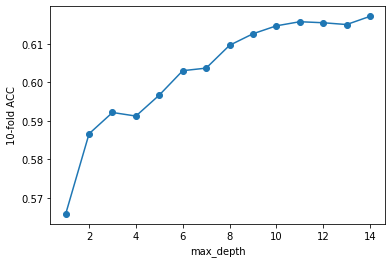

Train:  0.6762
Test:   0.6148


In [67]:
# Modelo 4. Tfidf filter features  + stop_words
optimal_rfmodel (15, X_train_tfidf_complex_sw, amazon_train['sentiment_trilabel'], 
                     X_test_tfidf_complex_sw, amazon_test['sentiment_trilabel'])

In [68]:
# Probamos con otros valores de max_depth pj para el valor a 8
rdModel4 = RandomForestClassifier(max_depth=8,
                                 n_estimators=200,max_features='sqrt').fit(X_train_tfidf_complex_sw,amazon_train['sentiment_trilabel'])

print("Train: ",rdModel4.score(X_train_tfidf_complex_sw, amazon_train['sentiment_trilabel']))
print("Test: ", rdModel4.score(X_test_tfidf_complex_sw, amazon_test['sentiment_trilabel']))

Train:  0.6421333333333333
Test:  0.6106


                    TfidfVectorizer filter features           TfidfVectorizer filter features con stop_words

    max_depth         14    Noteb0         8    Noteb0            14   Noteb0          8     Noteb0
    Train           71.82   71.89%      65.18%  65.84%         67.62%  67.91%        64.21%  64.97%  
    Test            62.18%  62.84%      60.92%  61.68%         61.48%  62.12%        61.06%  61.48%   
    
    En ambos casos el resultado es similar un 65% en train y 61% en test para max_depth = 8, algo mejor el resultado del primer modelo.
    
    TfidfVectorizer filter features sin stop_words con max_depth a 8 + con un score de 61% para test y 65% aprox. para train pero no mejoramos el resultado del notebook anterior (66% train y 62% test)

### Predicciones

In [69]:
# Aplicamos esta predicción sobre el modelo con mejores resultados CountVectorizer filter features sin aplicar stop_words
# y para el modelo con max_depth=8
for i in random.sample(range(0, len(df_amazon_clean)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(df_amazon_clean, i, 'reviewText', 'sentiment_trilabel', rdModel, cv_complex)


Review no. 7474
Actual sentiment: neu
Prediction: ['pos']

Review no. 14999
Actual sentiment: pos
Prediction: ['pos']

Review no. 13463
Actual sentiment: pos
Prediction: ['pos']

Review no. 6369
Actual sentiment: neg
Prediction: ['neg']

Review no. 14602
Actual sentiment: pos
Prediction: ['pos']


In [70]:
# Aplicamos esta predicción sobre el modelo con mejores resultados TfidfVectorizer filter features sin aplicar stop_words
# y para el modelo con max_depth=8
for i in random.sample(range(0, len(df_amazon_clean)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(df_amazon_clean, i, 'reviewText', 'sentiment_trilabel', rdModel3, tfidf_complex)


Review no. 2387
Actual sentiment: neu
Prediction: ['pos']

Review no. 10596
Actual sentiment: neg
Prediction: ['neg']

Review no. 16716
Actual sentiment: neg
Prediction: ['neg']

Review no. 14011
Actual sentiment: pos
Prediction: ['pos']

Review no. 13490
Actual sentiment: pos
Prediction: ['pos']


Observamos que en la clasificación multiclase, algunas predicciones no han sido las esperadas en las Reviews no. 7474 y 2387

### Conclusiones para el problema de clasificación multiclase

    Aplicando estas técnicas para la extracción de carácterísticas

    CountVectorizer filter features
    TfidfVectorizer filter features

    y sus combinaciones con stop_words junto con un modelo LogisticRegression para el problema de regresión multiclase.

    Concluimos que el mejor resultado corresponde a la segunda técnica:

    "TfidfVectorizer filter features" sin stop_words (accurary en test 61% y para  train 65%) con max_depth = 8

### Conclusión 

    Partiendo del dataframe del notebook anterior guardado en df df_newamazon, se aplica un preprocesado y lemmatización y el df resultante es df_amazon_clean.
    
    Para el problema de clasificación binaria, aplicamos estas técnicas para la extracción de carácterísticas:

    - CountVectorizer simple
    - CountVectorizer filter features
    - TfidfVectorizer simple
    - TfidfVectorizer filter features
    y sus combinaciones con stop_words junto con un modelo LogisticRegression
    
    Para el problema de clasificación multiclase, aplicamos las técnicas:
    - CountVectorizer filter features
    - TfidfVectorizer filter features    
    y sus combinaciones con stop_words junto con un modelo RandomForest.

    Los mejores resultados han sido:
    
    Clasificación binaria:    TfidfVectorizer filter features" sin stop_words (accurary en test 77.5%)         
    Clasificación multiclase: TfidfVectorizer filter features" sin stop_words (accurary en test 61% y para train 65%)  
    
    
    Sin el proprocesado de los datos los mejores resultados fueron:
    
    - Clasificación binaria:    TfidfVectorizer filter features" sin stop_words (accurary en test 78.36%)         
    - Clasificación multiclase: TfidfVectorizer filter features" sin stop_words (accurary en test 62% y para train 65%)    

    Concluimos que se obtienen peores resultados con el tratamiento de la información (procesado de los datos + 
    lemmatizacion) aplicado en este notebook con respecto a los resultados del notebook anterior.
    
    En ambos notebooks, los resultados son igualmente mejores para el problema de clasificación binario ya que entendemos 
    que es más difícil la predicción de la clase neutra en la clasificación multiclase, tal y como se observan en los resul-tados obtenidos.